# Homework 7 - Monte Carlo and Fast Exponential Transform

## Problem 0 (45 points) - Metroplis-Hastings algorithm

Suppose we have 10 particles with positions $x_i$  resting in potential well $V(x)= x^4-x^2-0.1x$:

Text(0, 0.5, 'V(x)')

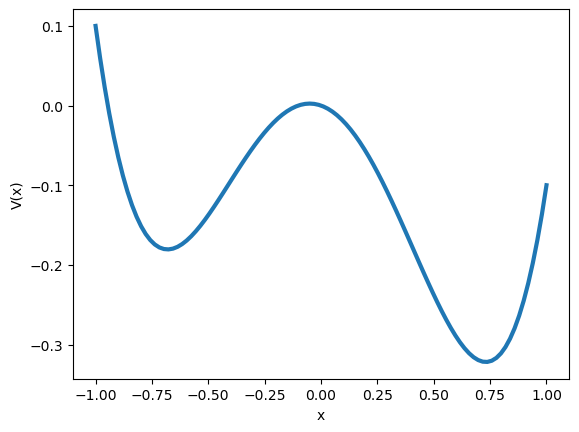

In [140]:
import numpy as np
import matplotlib.pyplot as plt

V = lambda x: x**4 - x**2 - 0.1*x # confining potential

xx = np.linspace(-1, 1, 100)
plt.plot(xx, V(xx), linewidth=3)
plt.xlabel('x')
plt.ylabel('V(x)')

If the particles have charges $q_i$, then the total energy of the system is
$$
H(\boldsymbol{x}) = \sum_{\text{pairs} (i,j)} \frac{q_iq_j}{|x_i-x_j|} + \sum_i V(x_i).
$$
According to statistical physics, if the particles are in thermal equillibrium at temperature $T$, then probability distribution of particles will be
$$
p(\boldsymbol{x}) = Z^{-1} e^{-H(\boldsymbol{x})/T},
$$
where $Z$ is a normalizing constant.


We will use the Metroplis-Hastings algorithm to find the expected number of particles in the right well ($x>0$).

The following function will generate our initial condition.

In [141]:
def gen_pts(npart=10):
    ' Generate n charged particles with random positions and charges '
    xs = 2*np.random.rand(npart) - 1 # uniformly distributed intial condition
    qs = np.random.rand(npart)
    return xs, qs

### Part A (5 points)
In the Metroplis-Hastings algorithm, we propose a new sample based on the previous sample:
$$
\boldsymbol{y}_{k+1} = F_i(\boldsymbol{x}_{k})
$$
For this problem, we shall need three kinds of steps one for moving our particles. In the first kind of step, which we call `walk_step`, will move the particles slightly:
$$
y_{i,k+1} = x_{i,k} + \delta W_{i,k},
$$
where $W_{i,k}$ is a standard normal random variable.
In the second kind of step (`swap_step`), we will randomly permute the particles:
$$
y_{i,k+1} = x_{P(i),k},
$$
where $P$ is a random parmutation.
The final kind of step (`flip_step`) will move one random particle ($j_k$) to the other well.
$$ 
y_{i,k+1} = \begin{cases} -x_{i,k} & i == j_{k}\\ x_{i,k} &\text{o.w.}\end{cases}
$$

The overall rule for generating the $y_{i,k+1}$ will be to do a `swap_step` with probability $a$, a `flip_step` with probability $b$, or `walk_step` if we do neither of the other steps.

Once we have generated the proposed step $\boldsymbol{y}_{k+1}$, the Metroplis-Hastings algorithm says that we accept it (i.e. set $\boldsymbol{x}_{k+1}=\boldsymbol{y}_{k+1}$) with probability $\min(p(\boldsymbol{y}_{k+1})/p(\boldsymbol{x}_{k}),1)$. If the step is rejectect, we set $\boldsymbol{x}_{k+1}=\boldsymbol{x}_{k}$.

Fill in the functions below to allow us to generate the next sample in the Metrpolis-Hastings alogirthm.

In [145]:
def walk_step(xs, delta = 0.1):
    """
    Slightly jiggers the particles in xs according to a (scaled) standard normal distribution.

    Parameters:
    xs: An ndarray of particles to be jiggered.
    delta: Scales the standard normal distribution to determine the magnitude of the jiggering.

    Returns:
    ys: An ndarray of the jiggered particles.
    """
    n = len(xs)
    W = np.random.normal(0, 1, n)
    ys = xs + delta * W
    return ys

def swap_step(xs):
    """
    Randomly shuffles the particles in xs.

    Parameters:
    xs: An ndarray of particles to be shuffled.

    Returns:
    ys: An ndarray of shuffled particles.
    """
    ys = np.random.permutation(xs)
    return ys

def flip_step(xs):
    """
    Randomly changes the sign of a single particle in xs.

    Parameters:
    xs: An ndarray of particles to be shuffled.

    Returns:
    ys: An ndarray of shuffled particles.
    """
    n = len(xs)
    
    # Randomly select a particle whose sign to flip
    flip_index = np.random.randint(n)
    
    # Copy xs and flip the sign of the randomly selected particle.
    ys = xs.copy()
    ys[flip_index] = -xs[flip_index]
    return ys

def mc_step(xs, p, a=0.1, b=0.1):
    """
    Randomly performs a swap, flip, or walk step on a set of particles.

    Parameters:
    xs: An ndarray of particles to be updated.
    p: The probability density function of the positions of the particles, given the
       the total energy of the system.
    a: The probability that the step will be a swap step. (0 <= a <= 1; a + b <= 1)
    b: The probability that the step will be a flip step. (0 <= b <= 1; a + b <= 1)

    Returns:
    ys: An ndarray of updated particles.
    """
    # Randomly determine which step (swap, flip, or walk) will be
    # taken based on probabilities a and b.
    step = None
    step_draw = np.random.rand()
    if step_draw <= a:
        step = swap_step
    elif step_draw > a and step_draw <= a + b:
        step = flip_step
    else:
        step = walk_step

    # Determine whether to accept the step and return the
    # (new or unchanged, appropriately) particle positions.
    accept_threshold = min(p(ys)/p(xs), 1)
    accept_draw = np.random.rand()
    if accept_draw <= accept_threshold:
        ys = step(xs)
    else:
        ys = xs
    return ys

### Part B (15 points) - Note the weight of this question
A Monte Carlo scheme will only converge quickly if the generated samples rapidly explore the state space (i.e. the potential particle positions).

Technically `walk_step` is capable of reordering the particles and moving particles to the other well and therefore exploring the state space.
Why will introducing `swap_step` and `flip_step` allow our scheme to converge faster? 

-----------

Since our random walk in `walk_step` is drawn from a symmetric (specifically, $\mathcal{N}(0,1)$) distribution, particles may---at least in the short term---be relatively stationary, with their positions oscillating back and forth due to successive walk steps with opposite signs. Eventually, with enough burn-in periods, the probability of our particles remaining "almost stationary" in this way diminishes, and the distribution of our particles will almost certainly converge to the underlying distribution.

However, if we periodically flip the position of a (randomly selected) particle over the y-axis using `flip_step`, we give our particles the opportunity to explore other parts of the state space much more quickly. For example, we can imagine a particle $i$ whose initial position is towards the left of the state space, e.g., $x_{i,0} = -1$. In order for this particle to explore the right end of the state space (e.g., get to $x_{i,k} = +1$) using `walk_step` alone, we would need numerous positive draws from $\mathcal{N}(0,1)$ (outnumbering or "out-scaling" any negative draws from $\mathcal{N}(0,1)$). Even in the "best-case scenario" where not a single negative walk step is drawn for particle $i$, it would still take many successive positive draws from $\mathcal{N}(0,1)$ to move it from $-1$ to $+1$ (since our $\delta$ value scaling the walk distance defaults to $0.1$). If particle $i$ happens to be moved with a `flip_step`, on the other hand, its position will move from $-1$ to $+1$ in a single turn. It would then have the opportunity to explore the right half of the state space over its next several walk steps (since the probability of being flipped back to the left half of the state space right away is small). In short, `flip_step` allows our particles to much more quickly explore opposite halves of the state space than `walk_step` would alone.

Moreover, while `flip_step` allows *one particle at a time* to explore the entire state space more quickly, shuffling our particles using `swap_step` allows *all of our particles to simultaneously* explore the entire state space more quickly. For example, we can imagine two of our particles, $i$ and $j$, starting on opposite ends of the state space (e.g., $x_{i,0} = -1$ and $x_{j,0} = +1$), and having ten turns to explore the surrounding parts of the state space through walk steps. If the positions of those particles are then swapped using `swap_step` (e.g., so that $x_{i,11} \approx +1$ and $x_{j,11} \approx -1$), then each particle now gets the opportunity to explore a different part of the state space. We can also imagine a scenario where all ten of our particles happen to start in the left half of the state space. To explore the right half of the space without `swap_step`, we would need to wait for *all* of our particles to rack up several positive walk steps and/or be "transported" with `flip_step`. With `swap_step`, once just a few of our particles make their way to the right half of the space through walk or flip steps, the remaining particles can much more quickly reach the right half of the space by having their positions exchanged with those already on the right. In short, by periodically shuffling the positions of all our particles, `swap_step` allows each particle to more quickly get exposure to different parts of the state space (so long as the particles are not all clustered in the same spot at the time of the swap).

### Part C (10 points)
Complete the function `mcmc_sim`, which generates the samples $\boldsymbol{x}_{1},\;\boldsymbol{x}_{2},\;\ldots$. You will need to initialize the system with `gen_part` and then run `nburn` steps to allow the system to converge to it's equillibrium distribution. After that initialization period, generate `nsamp` new samples and save them. The function should then return those saved samples.

Once the function is completed, use it with `nsamp = 10**4` and `nburn = 10**2` to estimate the number of particles in the right well.

In [231]:
def mcmc_sim(nsamp, nburn, npart=10, T = 2):
    """
    Generates a random set of points (and corresponding) charges
    and uses the Metropolis-Hastings algorithm to draw multiple
    samples of the positions of those particles under thermal
    equilibrium.

    Parameters:
    nsamp: The number of samples of the particles to generate/
           iterate through.
    nburn: The number of Markov Chain steps to iterate (or "burn")
           through in order for the distribution of particle
           positions to converge to the desired distribution.
    npart: The number of particles to be modeled.
    T: The temperature at which the particles are in thermal
       equilibrium.

    Returns:
    positions: A (nsamp x npart) matrix, where each row is a
               sample of the positions of the npart particles.
    """
    # Start with randomly generated particles and corresponding
    # charges.
    xs, qs = gen_pts(npart)

    # Compute total energy of the system ("H") based on the
    # particle positions and charges. 
    def total_energy(xs, qs):
        """
        Computes the total energy of a system of npart particles
        under thermal equilibrium.

        Parameters:
        xs: An ndarray of particles in the system.
        qs: An ndarray of the charges of the particles
            in the system.

        Returns:
        H: The total energy of the system.
        """
        H = 0
        for i in range(npart):
            for j in range(npart):
                if i != j:
                    H += qs[i] * qs[j] / abs(xs[i] - xs[j])
        for i in range(npart):
            H += V(xs[i])
        return H

    # Probability density function given total energy of the
    # system and temperature of thermal equilibrium.
    p = lambda xs : np.exp(-total_energy(xs, qs) / T)

    # Stage 1: Burn through nburn Markov Chain steps to
    # converge to the desired distribution.
    for i in range(nburn):
        xs = mc_step(xs, p)

    # Stage 2: Perform nsamp Markov Chain steps and save
    # the results of each.
    positions = np.zeros((nsamp, npart))
    for i in range(nsamp):
        positions[i] = xs
        if i != (nsamp - 1):
            # We don't need to update xs during the final
            # Markov Chain step
            xs = mc_step(xs, p)
    return positions

As shown below, averaging over 10,000 samples, we estimate that approximately 5 (i.e., half) of the particles in the system will be in the right well.

In [242]:
### Analysis

# Run simulation
positions = mcmc_sim(nsamp = 10**4, nburn = 10**2)

# Count all particles in the right well
# (all particles whose position is >0)
right_count = np.zeros(positions.shape[0])
for i in range(positions.shape[0]):
    for j in range(positions.shape[1]):
        if positions[i,j] > 0:
            right_count[i] += 1

print(np.mean(right_count))

5.1377


### Part D (5 points)
Make a histogram of the particle positions using the same samples as in the previous question. Note that for this problem, we don't distinguish between particles $i$ and $j$, so you should "flatten" the samples into a one-dimensional array before plotting.

----

Below, we show a histogram of the positions of our $10,000 \times 10 = 100,000$ particles. We also overlay a plot of $V(x) = x^4 - x^2 - 0.1x$ (flipped over the x-axis, scaled, and shifted upwards, so that it can be compared against our histogram). We see that the histogram rather nicely fits the contours of our (shifted/scaled) graph of $V(x)$, illustrating that the Metropolis-Hastings algorithm has allowed us to successfully approximate the distribution of particles.

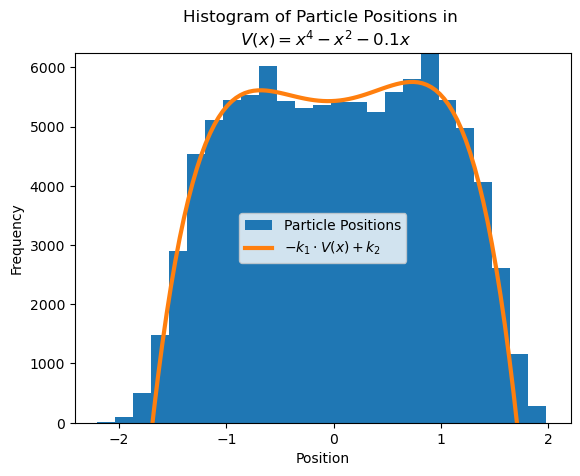

In [243]:
# "Flatten" samples into a single array
all_positions = np.ndarray.flatten(positions)

# Histogram of particle positions
hist = plt.hist(all_positions, bins = 25, label = "Particle Positions")

# Plot function V (flipped and scaled)
# Shows that histogram follows contours of V
xx = np.linspace(-2, 2, 100)
plt.plot(xx, -(V(xx))*1000 + np.sort(hist[0])[-8], linewidth = 3, label = "$-k_1 \cdot V(x) + k_2$")

# Labels and aesthetics
plt.ylim(0, np.sort(hist[0])[-1])
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.title("Histogram of Particle Positions in \n $V(x) = x^4 - x^2 - 0.1x$")
plt.legend(loc = "center")

plt.show()


### Part E (10 points)
For this problem set `nsamp = 10**3`. Compare the estimate with `nburn = 0` and `nburn = 10**3`. Which one is closer to your estimate from the previous question and why?

----------

In the simulations below, when we set `nburn = 0`, our estimated number of particles in the right well is roughly 5.5, while when we set `nburn = 10**3`, our estimated number of particles is roughly 5 (what we previously estimated in Part C). Thus, our estimate using `nburn = 10**3` is more accurate than our estimate with `nburn = 0`, though the latter estimate isn't *too* far off. When we give the Metropolis-Hastings algorithm the opportunity to "burn" through many (ignored) iterations, we allow the Markov Chain of particle positions to converge to the true distribution of particle positions *before* we begin writing those positions down. In our simulation with `nburn = 10**3`, we gave the algorithm ample time to converge to the underlying distribution of particles, making our average number of particles in the right well close to what we estimated previously. In our simulation with `nburn = 0`, we began recording particle positions before giving the algorithm any opportunity to converge to the underlying distribution. The fact that our estimate is roughly 5.5 (not *too* far off from 5) suggests that by the time $10^3$ Markov Chain steps were performed, the algorithm *did* converge to the underlying distribution --- but our first several samples (those taken before this convergence began) are skewing the estimate upwards.

In [271]:
# Simulation with nburn = 0
positions_0 = mcmc_sim(nsamp = 10**3, nburn = 0)

# Count all particles in the right well
# (all particles whose position is >0)
right_count_0 = np.zeros(positions_0.shape[0])
for i in range(positions_0.shape[0]):
    for j in range(positions_0.shape[1]):
        if positions_0[i,j] > 0:
            right_count_0[i] += 1

print("Estimated Number of Right-Well Particles with nburn = 0:  ", np.mean(right_count_0))


# Simulation with nburn = 10**3
positions_10k = mcmc_sim(nsamp = 10**3, nburn = 10**3)

# Count all particles in the right well
# (all particles whose position is >0)
right_count_10k = np.zeros(positions_10k.shape[0])
for i in range(positions_10k.shape[0]):
    for j in range(positions_10k.shape[1]):
        if positions_10k[i,j] > 0:
            right_count_10k[i] += 1

print("Estimated Number of Right-Well Particles with nburn = 1e3:", np.mean(right_count_10k))

Estimated Number of Right-Well Particles with nburn = 0:   5.461
Estimated Number of Right-Well Particles with nburn = 1e3: 4.952


## Problem 1 (30 points) - Fast Exponential Transform

In this problem, we will experiment with a common fast algorithm for applying exponential functions in 1D. Suppose we have sorted points $x_0,\dots,x_{n-1} \in \mathbb{R}$ and "weights" $c_0,\dots,c_{n-1}$ and we want to compute the sum
$$f_i = \sum_{j=0}^{n-1} \exp(-|x_i-x_j|) c_j,$$
for $i=0,1,2,\dots,n-1.$ 

### Part A (5 points)

The most straightforward way to find $f_0,\dots,f_{n-1}$ is via linear algebra. Make a big matrix $E$ with $E_{i,j}= \exp(-|x_i-x_j|).$ If we set $c$ to be the vector of weights, and $f$ to be the vector of values we want, then we get
$$f = Ec.$$

Implement a routine `exp_transform(x,c)` which takes in a vector of $x$ "positions" ($x_0<x_1<\dots<x_{n-1}$) and a vector of weights $c$ and outputs the corresponding $f$ values as a vector using this approach.

Test its performance in terms of time by taking 200,400,800,1600,3200,6400,10000 random normal numbers for the $x$ positions and setting all of the $c$'s to be one (only time the `exp_transform(x,c)` routine, not the time to generate $x$ or sort it). Plot your results. If the latter trials are taking too long then feel free to exclude them from your results (just make a note).

--------------

Below, we define our `exp_transform(x,c)` function.

In [125]:
def exp_transform(x, c):
    """
    Performs the exponential transform given a vector of positions and a
    corresponding vector of weights.

    Parameters:
    x: An ndarray (length n) consisting of positions.
    c: An ndarray (also length n) consisting of weights.

    Returns:
    f: An ndarray (length n) consisting of exponentiated values. 
    """
    n = len(x)
    
    # Compute the matrix E, whose entries are the exponentiated negative distances between two positions.
    E = np.zeros(shape = (n,n))
    for i in range(n):
        for j in range(n):
            E[i,j] = np.exp(-np.abs(x[i]-x[j]))

    # Compute the vector of values f as the matrix product of E and c.
    f = E @ c
    return f


Below, we plot the runtime of our exponential transform algorithm for increasingly large collections of points ($n \in \{200, 400, 800, 1600, 3200, 6400, 10000\}$). Observe that the plot is roughly collinear with the graph of a quadratic function (in particular, $f(n) = 2 \times 10^{-6} n^2$), illustrating that our algorithm is $\mathcal{O}(n^2)$.

In [119]:
import time # to compute runtimes
from tqdm import tqdm # progress bar

# Timing (borrowed/adapted from HW0)
def get_runtimes_slow(ns):
    """
    Computes runtimes of the "not fast" exponential transform for various
    numbers of positions, using "weights" of 1.

    Parameters:
    ns, an ndarray of numbers of positions.

    Returns:
    ts, an array of runtimes corresponding to each size in ns.
    """
    ts = []
    for n in tqdm(ns):
        xs = np.random.normal(0, 1, size = n) # x's are ~ N(0,1)
        xs.sort() # Sort the x's (ascending)
        cs = np.ones(shape = n) # "Weights" are a vector of 1s
        t0 = time.time()
        fs = exp_transform(xs, cs)
        t1 = time.time()
        ts.append(t1 - t0)
    return ts

# Analysis --- runtimes for various n's
ns_slow = np.array([200, 400, 800, 1600, 3200, 6400, 10000])
ts_slow = get_runtimes_slow(ns_slow)

100%|██████████| 7/7 [04:45<00:00, 40.81s/it]


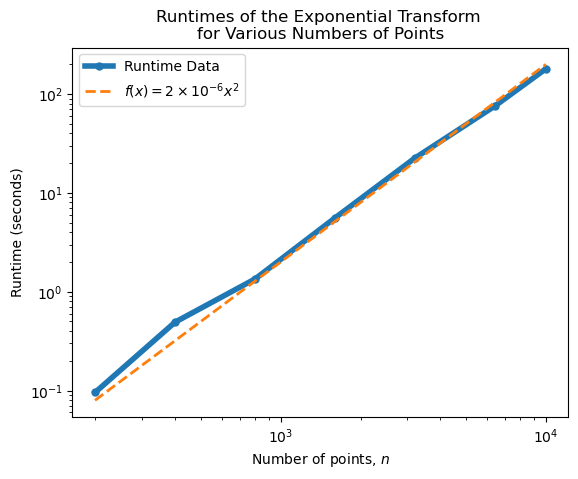

In [277]:
# Plot of the runtime data
plt.plot(ns_slow, ts_slow, linewidth = 4, marker = "o", markersize = 5, label = "Runtime Data")

# Plot of a quadratic function, showing that our algorithm is O(n^2)
xx = np.logspace(2.3, 4, 100)
yy = 0.000002 * xx ** 2
plt.plot(xx, yy, label = r"$f(x) = 2 \times 10^{-6}x^2$", linestyle = "--", linewidth = 2)

# Labels and formatting
plt.loglog()
plt.xlabel("Number of points, $n$")
plt.ylabel("Runtime (seconds)")
plt.title("Runtimes of the Exponential Transform \nfor Various Numbers of Points")
plt.legend(loc = "best")
plt.show()

Unfortunately, for large $n,$ (think 10's of thousands to millions) creating and storing $E$ can get expensive, and applying the matrix will take $O(n^2)$ operations. Let's try to find a better way. For a given point $x_i$ let $L_i$ be the collection of all the points to the left of $x_i$ and $R_i$ be the collection of all points to the right of $x_i.$ Then

$$ f_i = c_i + \sum_{j \in L_i} \exp(x_j-x_i) c_j +\sum_{j \in R_i} \exp(x_i-x_j) c_j.$$

Set $w_i = \sum_{j \in L_i} \exp(x_j-x_i) c_j,$ and $u_i = \sum_{j \in R_i} \exp(x_i-x_j) c_j.$ Then, after some arithmetic, we see that
$$w_{i+1} = \exp(x_i-x_{i+1}) (w_i + c_i)$$
and
$$u_{i-1} = \exp(x_{i-1}-x_{i}) (u_i + c_i)$$

### Part B (10 points)

Write a function, `sweep_right(x,c)` which computes all the $w$'s using the above recurrence formula. Your routine should start with $w_0 = 0,$ and compute $w_1 = \exp(x_0-x_1)*c_0,$ then $w_2 = \exp(x_1-x_2)*(w_1+c_1),$ and so on.

Write a function, `sweep_left(x,c)` which computes all the $u$'s using the above recurrence formula. Your routine should start with $u_{n-1} = 0,$ and compute $u_{n-2} = \exp(x_{n-2}-x_{n-1})*c_{n-1},$ then $u_{n-3} = \exp(x_{n-3}-x_{n-2})*(u_{n-2}+c_{n-2}),$ and so on. When implementing this method, it might be helpful to use `numpy.flip` to reverse the $x$ and $c$ vectors to make your code look similar to `sweep_right` - just make sure to check the signs in the exponents and to make sure that the output is flipped properly.

In [3]:
def sweep_right(x, c):
    """
    For each position x_i in x, computes a weighted sum of the exponentiated
    distances between x_i and each point to its left.

    Parameters:
    x: An ndarray (length n) consisting of positions.
    c: An ndarray (also length n) consisting of weights.

    Returns:
    w: An ndarray (length n) consisting of weighted sums of exponentiated
    distances between each points and those points to its left. 
    """
    n = len(x)

    # Initialize w vector
    w = np.empty(n)
    
    # w_0 = 0, since x0 has no points to its left.
    w[0] = 0

    # Iteratively computes w_1 through w_(n-1)
    for i in range(n-1):
        w[i+1] = np.exp(x[i] - x[i+1]) * (w[i] + c[i])

    return w

def sweep_left(x, c):
    """
    For each position x_i in x, computes a weighted sum of the exponentiated
    distances between x_i and each point to its right.

    Parameters:
    x: An ndarray (length n) consisting of positions.
    c: An ndarray (also length n) consisting of weights.

    Returns:
    w: An ndarray (length n) consisting of weighted sums of exponentiated
    distances between each points and those points to its right.
    """
    n = len(x)

    # Initialize u vector
    u = np.empty(n)

    # u_(n-1) = 0, since x_(n-1) has no points to its right.
    u[-1] = 0

    # Iteratively computes u_(n-2) through u_0
    for i in range(n-1):
        u[-(i+2)] = np.exp(x[-(i+2)] - x[-(i+1)]) * (u[-(i+1)] + c[-(i+1)])

    return u

# TEST
# x = np.random.rand(5)
# x.sort()
# c = np.ones(5)
# print("x: ", x)
# print("c: ", c)
# w = sweep_right(x, c)
# u = sweep_left(x, c)
# print("w: ", w)
# print("u: ", u)
# print("f: ", exp_transform(x,c))
# print("f*:", c + w +u)

### Part C (10 points)

Write a function `fast_exp_transform(x,c)` which takes in a vector of $x$ "positions" ($x_0<x_1<\dots<x_{n-1}$) and a vector of weights $c$ and outputs the corresponding $f$ values as a vector using your `sweep_left` and `sweep_right` functions and the formula above.

Test its accuracy against `exp_transform` for a small number of points (100 let's say).

Test its performance in terms of time by taking 200,400,800,1600,3200,6400,10000 random normal numbers for the $x$ positions and setting all of the $c$'s to be one (only time the `fast_exp_transform(x,c)` routine, not the time to generate $x$ or sort it). Plot your results. *Make sure the points are sorted!* 

How many points can you do? 

What is the crossover point between this approach and `exp_transform` if any? i.e. for what value of $n$ will the two take about the same time?

What is the computational complexity (in $n$) of your `fast_exp_transform` code?

-------------

Our `fast_exp_transform(x,c)` function is below.

In [85]:
def fast_exp_transform(x, c):
    """
    Performs the fast exponential transform given a vector of 
    positions and a corresponding vector of weights.

    Parameters:
    x: An ndarray (length n) consisting of positions.
    c: An ndarray (also length n) consisting of weights.

    Returns:
    f: An ndarray (length n) consisting of exponentiated values. 
    """
    # Compute w and u vectors.
    w = sweep_right(x, c)
    u = sweep_left(x, c)

    # Compute the vector of values f.
    f = c + w + u
    return f

Now, we check the accuracy of our `fast_exp_transform(x,c)` algorithm against our slower `exp_transform(x,c)` algorithm for $n = 100$. The difference in the norms of the $f$ vectors generated by the two algorithms is on the order of `1e-14`, so we can rest easy knowing that our fast transform approach is accurate.

In [ ]:
### Test accuracy of the fast transform against the "not fast" transform using n = 100.
x = np.random.normal(0, 1, 100)
x.sort()
c = np.ones(100)
error = np.linalg.norm(exp_transform(x,c)) - np.linalg.norm(fast_exp_transform(x,c))
print(error) #e-14 --- great!

Below, we plot the runtime of our fast exponential transform algorithm for increasingly large collections of points (including $n \in \{200, 400, 800, 1600, 3200, 6400, 10000\}$) --- but this time, to illustrate how much more efficient our algorithm is, we also compute and plot runtimes for $n = 100,000$ and $n = 1,000,000$. In particular, we show with additional computations below that our fast algorithm can perform the exponential transform on 1 million positions in just ~3 seconds, a significant improvement over our original algorithm (which required several *minutes* to perform the exponential transform on just 10 thousand positions).

In terms of computational complexity, our fast algorithm involves computing an $n$-dimensional vector $w$ and an $n$-dimensional vector $u$, and then summing $w$, $u$, and an $n$-dimensional vector $c$. Computing each element of $w$ involves four operations (one subtraction, one exponentiation, one addition, and one multiplication, since $w_{i+1} = \exp(x_i-x_{i+1}) (w_i + c_i)$). Since there are $n$ elements in $w$, this gives $4n$ operations. Computing each element of $u$ similarly involves four operations (since $u_{i-1} = \exp(x_{i-1}-x_{i}) (u_i + c_i)$), and so since there are $n$ elements in $u$, this gives an additional $4n$ computations. Finally, summing $c + w + u$ involves an additional $2n$ computations (two additions for each of $n$ entries in the vectors). In total, then, our fast exponential transform algorithm requires $4 + 4 + 2 = 10$ computations, so is $\mathcal{O}(10n) = \mathcal{O}(n)$. Observe that our plot is roughly collinear with the graph of a linear function (in particular, $f(n) = 3 \times 10^{-6}n$), which visually shows that our fast algorithm is $\mathcal{O}(n)$.

Since our original algorithm is $\mathcal{O}(n^2)$ and our fast algorithm is $\mathcal{O}(n)$, we would only expect the algorithms to have comparable runtimes (i.e., have a crossover point) for $n = 1$ (the only $n > 0$ such that $n^2 = n$).

100%|██████████| 9/9 [00:03<00:00,  2.37it/s]


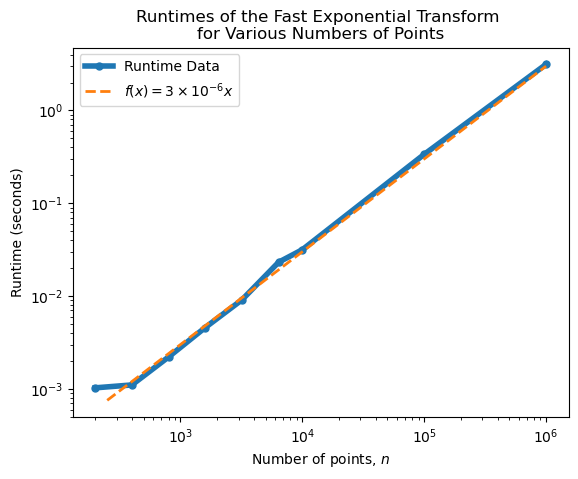

2.9971396923065186


In [279]:
### Timing (borrowed/adapted from HW0)
def get_runtimes_fast(ns):
    """
    Computes runtimes of the fast exponential transform for various numbers of positions,
    using "weights" of 1.

    Parameters:
    ns, an ndarray of numbers of positions.

    Returns:
    ts, an array of runtimes corresponding to each size in ns.
    """
    ts = []
    for n in tqdm(ns):
        xs = np.random.normal(0, 1, size = n) # x's are ~ N(0,1)
        xs.sort() # Sort the x's (ascending)
        cs = np.ones(shape = n) # "Weights" are a vector of 1s
        t0 = time.time()
        fs = fast_exp_transform(xs, cs)
        t1 = time.time()
        ts.append(t1 - t0)
    return ts

### Analysis --- runtimes for various n's
ns_fast = np.array([200, 400, 800, 1600, 3200, 6400, 10000, 100000, 1000000])
ts_fast = get_runtimes_fast(ns_fast)

### Plotting
# Plot of runtime data
plt.plot(ns_fast, ts_fast, linewidth = 4, marker = "o", markersize = 5, label = "Runtime Data")

# Plot of a linear function, showing that our algorithm is O(n)
xx = np.logspace(2.4, 6, 100)
yy = 3 * 10**(-6) * xx
plt.plot(xx, yy, linestyle = "--", linewidth = 2, label = r"$f(x) = 3 \times 10^{-6}x$")

# Labels and aesthetics
plt.loglog()
plt.xlabel("Number of points, $n$")
plt.ylabel("Runtime (seconds)")
plt.title("Runtimes of the Fast Exponential Transform \nfor Various Numbers of Points")
plt.legend(loc = "best")
plt.show()

### How high can we go?

# Our new method is significantly faster than our original method.
# For example, as performed below, we can perform the exponential
# transform on 1 million positions in just ~3 seconds.

# Setup
n = int(1e6)
x = np.random.normal(0, 1, n)
x.sort()
c = np.ones(n)

# Timing
t0 = time.time()
f = fast_exp_transform(x, c)
t1 = time.time()
print(t1 - t0)

### Part D (5 points)

Try to optimize both codes as much as possible. For example, you could try to vectorize the construction of the exponentials in the first approach. You could try to use `numba` to try to accelerate the second. You can precompute the exponentials of the distances between consecutive $x$ values and pass that as an optional argument to your sweeping routines. How much can you improve your code? This is an open-ended question and there is no "right" answer.

----------

Below, we attempt to improve our "slow" exponential transform algorithm by constructing E using two outer products and vectorized operations on the matrices formed. At least in our test below, this approach yields faster runtimes for relatively small $n$'s (specifically, $n \in \{200, 400, 800, 1600, 3200\}$), but is actually slightly slower than our for-loop approach for larger values of $n$ (specifically, $n \in \{6400, 10000\}$).

In [314]:
def exp_transform_new(x, c):
    """
    Performs the exponential transform given a vector of positions and a
    corresponding vector of weights. We attempt to make this faster than
    exp_transform(x, c) by using a vectorized approach to computing E,
    rather than using a for loop.

    Parameters:
    x: An ndarray (length n) consisting of positions.
    c: An ndarray (also length n) consisting of weights.

    Returns:
    f: An ndarray (length n) consisting of exponentiated values. 
    """
    n = len(x)

    # Vectorized approach to generating E
    E1 = np.outer(x, np.ones(n))
    E2 = np.outer(np.ones(n), x)
    E = np.exp(-abs(E1 - E2))

    # Compute the vector of values f as the matrix product of E and c.
    f = E @ c
    return f

# TEST
# x = np.random.rand(10)
# c = np.ones(10)
# print(exp_transform_new(x, c))

# TIMING TEST
def get_runtimes_slow_new(ns):
    """
    Computes runtimes of the "not fast" exponential transform for various
    numbers of positions, using "weights" of 1.

    Parameters:
    ns, an ndarray of numbers of positions.

    Returns:
    ts, an array of runtimes corresponding to each size in ns.
    """
    ts = []
    for n in tqdm(ns):
        xs = np.random.normal(0, 1, size = n) # x's are ~ N(0,1)
        xs.sort() # Sort the x's (ascending)
        cs = np.ones(shape = n) # "Weights" are a vector of 1s
        t0 = time.time()
        fs = exp_transform_new(xs, cs)
        t1 = time.time()
        ts.append(t1 - t0)
    return ts

# Analysis --- runtimes for various n's
ns_slow_new = np.array([200, 400, 800, 1600, 3200, 6400, 10000])
ts_slow_new = get_runtimes_slow(ns_slow_new)

print(ts_slow) # old runtimes
print(ts_slow_new)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [05:14<00:00, 44.89s/it]

[0.09608721733093262, 0.49255871772766113, 1.3445472717285156, 5.56341290473938, 22.43797779083252, 75.23977398872375, 180.4631371498108]
[0.09555268287658691, 0.41853857040405273, 1.3354408740997314, 5.135721206665039, 20.8692409992218, 82.40340185165405, 203.92213487625122]


Now, we attempt to improve our fast exponential transform by leveraging `numba`. At least in our test below, this approach yields faster runtimes for large values of $n$ (specifically, $n \in \{10^5, 10^6\}$), but actually is slower than our original algorithm for smaller values of $n$ (specifically, $n \in \{200, 400, 800, 1600, 3200, 6400, 10^4\}$).

In [313]:
from numba import jit

def fast_exp_transform_new(x, c):
    """
    Performs the fast exponential transform given a vector of 
    positions and a corresponding vector of weights.

    Parameters:
    x: An ndarray (length n) consisting of positions.
    c: An ndarray (also length n) consisting of weights.

    Returns:
    f: An ndarray (length n) consisting of exponentiated values. 
    """
    # Compute w and u vectors.
    w = sweep_right(x, c)
    u = sweep_left(x, c)

    # Compute the vector of values f leveraging numba.
    @jit#(float64[:](float64[:], float64[:], float64[:]))
    def f(i, j, k):
        i + j + k

    return f(c, w, u)

# TIMING TEST
def get_runtimes_fast_new(ns):
    """
    Computes runtimes of the fast exponential transform for various numbers of positions,
    using "weights" of 1.

    Parameters:
    ns, an ndarray of numbers of positions.

    Returns:
    ts, an array of runtimes corresponding to each size in ns.
    """
    ts = []
    for n in tqdm(ns):
        xs = np.random.normal(0, 1, size = n) # x's are ~ N(0,1)
        xs.sort() # Sort the x's (ascending)
        cs = np.ones(shape = n) # "Weights" are a vector of 1s
        t0 = time.time()
        fs = fast_exp_transform_new(xs, cs)
        t1 = time.time()
        ts.append(t1 - t0)
    return ts

### Analysis --- runtimes for various n's
ns_fast_new = np.array([200, 400, 800, 1600, 3200, 6400, 10000, 100000, 1000000])
ts_fast_new = get_runtimes_fast(ns_fast_new)

print(ts_fast) # old runtimes
print(ts_fast_new)


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

[0.0010268688201904297, 0.0011038780212402344, 0.0022084712982177734, 0.0045855045318603516, 0.009113311767578125, 0.02318120002746582, 0.03157997131347656, 0.3363826274871826, 3.1395041942596436]
[0.0010559558868408203, 0.0018017292022705078, 0.006327390670776367, 0.015011310577392578, 0.012915849685668945, 0.02599930763244629, 0.052736520767211914, 0.3222935199737549, 2.962932586669922]
